# TP SVG

### Data Structures

- List of tupples for (shape, color, coordinates)?


### Functions to implement:
- computing an SVG from a genotype;
- computing a PNG from a phenotype;
- computing a phenotype from a genotype;
- computing a fitness value from a phenotype;
- mutating a genotype;
- performing a crossover between two genotypes.

## Code a skeleton application
First, focus on the overall code structure and solution representation. 
Write a first version of your main script that loads the target image, create a “blank” approximation and compute its fitness without implementing any improvement algorithm yet. 
Test your solution representation by generating a random solution with one simple geometric shape (e.g., one square aligned with the pixel grid) to ensure the code structure works as expected

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from genotype import SVGShape, Circle, Ellipse, Rect

def load_img(image_path: str):
    img = Image.open(image_path)
    # Creates an array: [height, width, channels]
    grid = np.array(img)
    w = img.width
    h = img.height
    return (grid, w, h)




def generate_phenotype(width, height, genotype):
    # Create a blank image (canvas) to draw on. 
    img = Image.new("RGB", (width, height), "black") 
    draw = ImageDraw.Draw(img)

    for shape in genotype:
        # We render each shape 
        
        if isinstance(shape, Rect):
            # From (x, y, w, h) to (x0, y0, x1, y1)
            x1 = shape.x + shape.w
            y1 = shape.y + shape.h
            draw.rectangle([shape.x, shape.y, x1, y1], fill=shape.fill)
            
        elif isinstance(shape, Circle):
            # (cx-r, cy-r, cx+r, cy+r)
            x0 = shape.cx - shape.r
            y0 = shape.cy - shape.r
            x1 = shape.cx + shape.r
            y1 = shape.cy + shape.r
            draw.ellipse([x0, y0, x1, y1], fill=shape.fill)

        elif isinstance(shape, Ellipse):
            # (cx-rx, cy-ry, cx+rx, cy+ry)
            x0 = shape.cx - shape.rx
            y0 = shape.cy - shape.ry
            x1 = shape.cx + shape.rx
            y1 = shape.cy + shape.ry
            draw.ellipse([x0, y0, x1, y1], fill=shape.fill)

    # Convert back to a nparray for fitness calc
    return np.array(img)


# Calculate distance between phenotype and original image
# TODO: Check if other fitness calc are worth it
def compute_fitness(target, candidate):
    """
    Computes the Sum of Squared Differences between two img and phenotype.
    """
    # Cast to int64 because of squares
    diff = target.astype(np.int64) - candidate.astype(np.int64)
    
    # Square the differences and sum them up (L2 Norm penalizes large diff)
    return np.sum(diff ** 2)






## 1st Test

Very simple test, checking if starting logic works - i.e fitness looks logical and drawing shapes seems to work.

Base Fitness (Empty): 311127167257
Genotype size: 1 shape(s)
Fitness Score: 311180064712
Improvement: -52897455


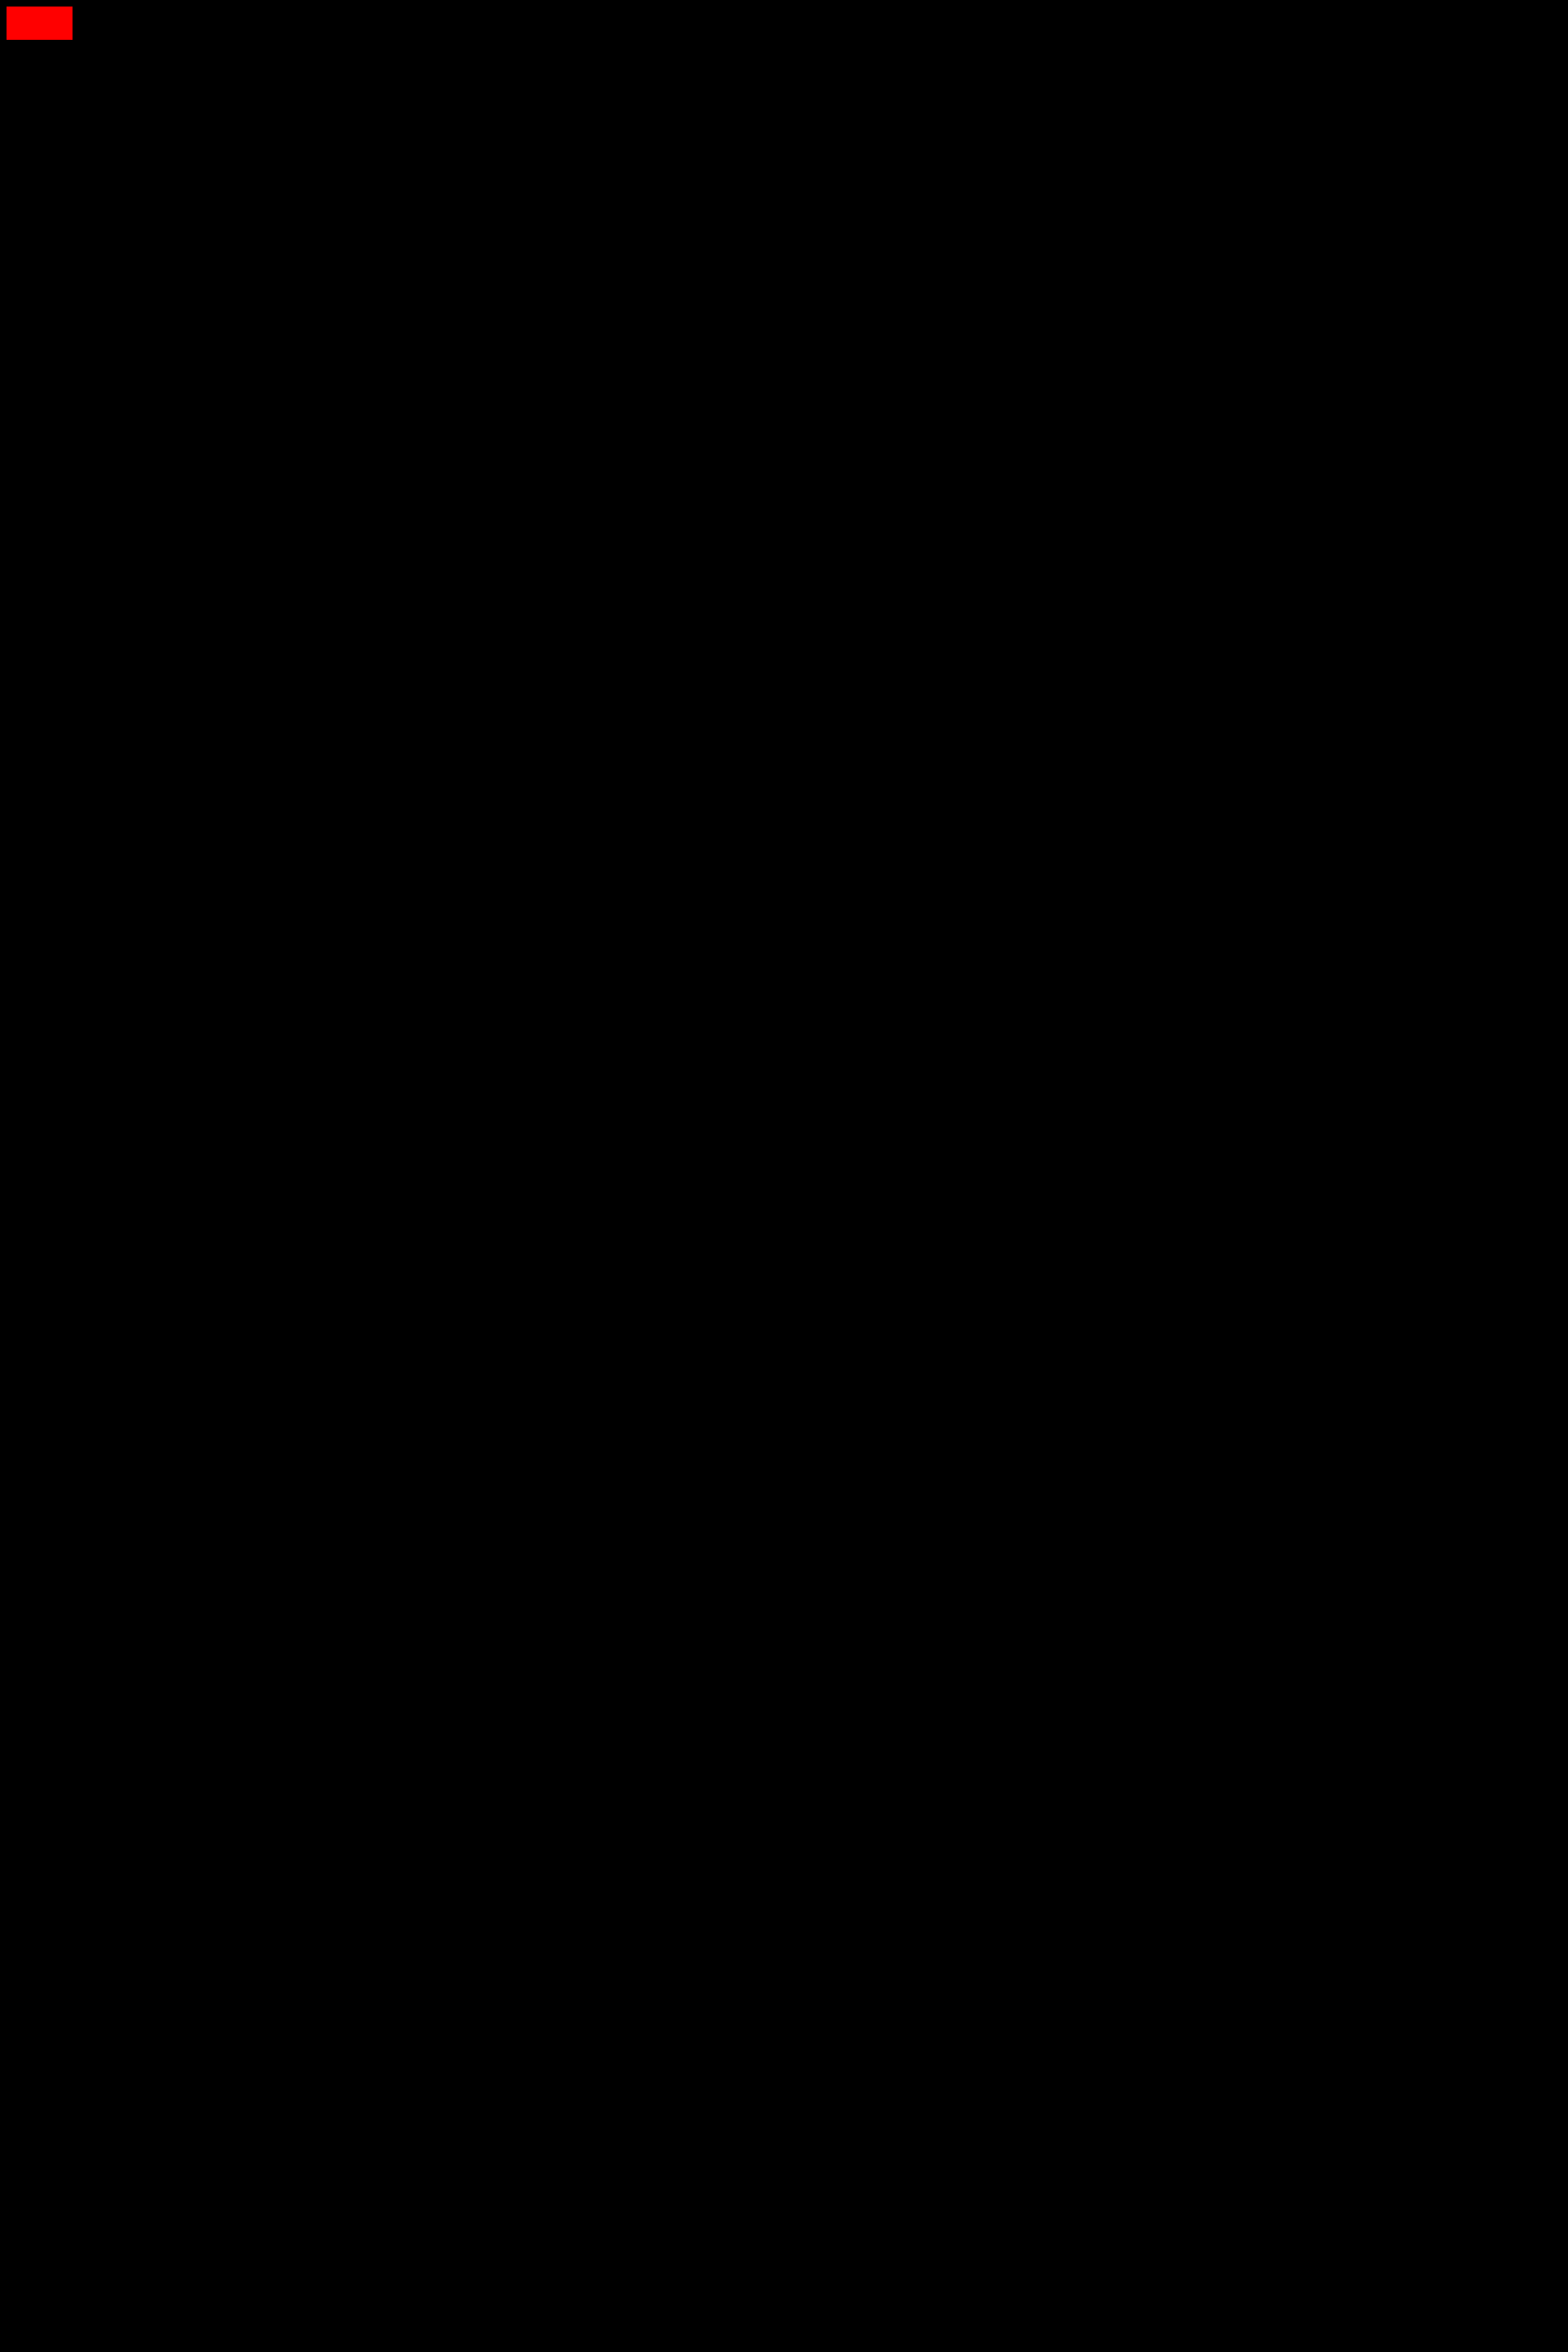

In [2]:
original_img, w, h = load_img("./test.png")

# Create blank canvas (All Black)
canvas = np.zeros(original_img.shape, dtype=np.uint8)
shapes = ["Rect", "Circle", "Ellipse"]

# TEST: Check fitness of empty canvas (Canvas vs Original)
# This gives you the "worst case" score to beat
base_fitness = compute_fitness(original_img, canvas)
print(f"Base Fitness (Empty): {base_fitness}")

# Create data structure -> list of tuples (genotype)
gen: list[SVGShape] = []

# Add 1 random (shape, color, coordinates)
new_rect = Rect(x=10, y=10, w=100, h=50, fill=(255, 0, 0))
gen.append(new_rect)

# Create corresponding pixel grid (phenotype)
phenotype = generate_phenotype(w, h, gen)

# Calculate distance between phenotype and original image (fitness)
fitness_score = compute_fitness(original_img, phenotype)

# Results
print(f"Genotype size: {len(gen)} shape(s)")
print(f"Fitness Score: {fitness_score}")
print(f"Improvement: {base_fitness - fitness_score}")

# Show generated img
gen_img = Image.fromarray(phenotype)
display(gen_img)

## Heuristics and Metaheuristics

### How to start well?
- Get the base colors of the image:
    - for example, make a grid of the image and take the average color of these rectangles?
    - Take the top 5-10 hues and start with a shape of each?

- Change the image size so there are fewer pixels and therefore a simpler problem

We'll start with the resize (because that will simplify visualization too) and we'll also define random sizes and colors.

In [3]:
import random

def load_img(image_path: str, max_size=512):
    img = Image.open(image_path)
    
    # Resize while maintaining aspect ratio
    img.thumbnail((max_size, max_size))
    
    # Ensure we are in RGB mode (removes Alpha channel if present, which simplifies math)
    img = img.convert("RGB")
    
    # Creates an array: [height, width, channels]
    grid = np.array(img)
    w = img.width
    h = img.height
    
    print(f"Image loaded and resized to: {w}x{h}")
    return (grid, w, h)


# Generates a random shape (Rect, Circle, Ellipse) with randomized size and position.
def get_random_shape(shape: type[SVGShape], w_img: int, h_img: int, min_size: int = 25): # TODO: check if 25 is not to big 

    # Random color (R, G, B)
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    
    if shape == Rect:
        # Width/Height: Random between min_size and full image size
        w = random.randint(min_size, w_img)
        h = random.randint(min_size, h_img)
        
        # X/Y: Position can be anywhere inside
        x = random.randint(0, w_img - w) 
        y = random.randint(0, h_img - h)
        
        return Rect(x, y, w, h, fill=color)
        
    elif shape == Circle:
        # Radius: Random between min_size (as approx diameter) and half smallest side
        max_r = min(w_img, h_img) // 2
        r = random.randint(min_size // 2, max_r)
        
        # Center: Randomly placed, ensuring the circle is mostly within bounds
        cx = random.randint(r, w_img - r)
        cy = random.randint(r, h_img - r)
        
        return Circle(cx, cy, r, fill=color)
        
    elif shape == Ellipse:
        # Radii: Randomize x and y radius independently
        max_rx = w_img // 2
        max_ry = h_img // 2
        
        rx = random.randint(min_size // 2, max_rx)
        ry = random.randint(min_size // 2, max_ry)
        
        cx = random.randint(rx, w_img - rx)
        cy = random.randint(ry, h_img - ry)
        
        return Ellipse(cx, cy, rx, ry, fill=color)



Image loaded and resized to: 341x512
Genotype size: 10 shape(s)
Fitness Score: 4,451,782,724
Improvement: 306,728,281,988


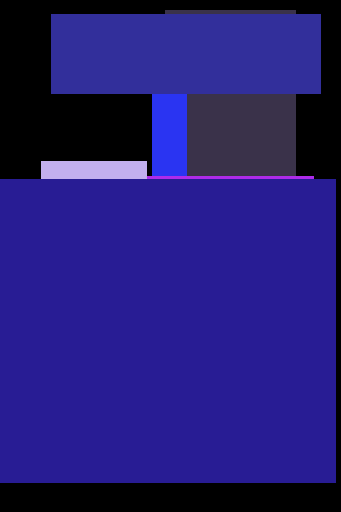

In [4]:
# 1. Load Image (using your updated function with default 512px)
original_img, w, h = load_img("./test.png")

old_fitness = fitness_score

gen: list[SVGShape] = []

# Loop to create 10 random Rectangles
for i in range(10):
    # We pass the class 'Rect' to your function
    new_shape = get_random_shape(Rect, w, h, min_size=25)
    gen.append(new_shape)

# Generate Phenotype (Render all 10 shapes onto one image)
phenotype = generate_phenotype(w, h, gen)

# Evaluate Fitness (Calculate distance)
fitness_score = compute_fitness(original_img, phenotype)

# Results
print(f"Genotype size: {len(gen)} shape(s)")
print(f"Fitness Score: {fitness_score:,}")
print(f"Improvement: {old_fitness - fitness_score:,}")

gen_img = Image.fromarray(phenotype)
gen_img

First let's implement a first draft of mutations. We will implement the easiest mutations:
- add
- recolor
- resize

For a cleaner code and easier use I will refactor genotype into a class that:
- Holds image dimensions
- The current list of shapes (what was the genotype up till now)

In [5]:
class Genotype:
    def __init__(self, w: int, h: int):
        self.w = w  # img width
        self.h = h  # img height
        self.shapes: list[SVGShape] = [] # DNA / list of shapes



Let's try to implement hill climbing (seems to be the simplest for now).

```
def  local_search(initial_solution):
    best  =  current  =  initial_solution
    while  not  stopping_condition(): 
    neighbour  =  mutate(current) 
    if  fitness(neighbour)  <  fitness(best):
        best  =  current  =  neighbour 
    elif  accept(neighbour):
        current  =  neighbour 
        
    return  best

```

In [6]:
import numpy as np
from utils import apply_mutation
from genotype import Genotype

def local_search(geno: Genotype, original_img: np.ndarray, shape_class: type[SVGShape], max_it: int = 1000) -> Genotype:
    """
    Performs a simple Hill Climbing Local Search to optimize the genotype.
    
    Args:
        geno: The starting genotype.
        original_img: The target image (numpy array).
        shape_class: The type of shape to use for 'add' mutations (Rect, Circle, etc.).
        max_it: Number of iterations to run.
    """
    
    # 1. Initialize Best Solution
    # We clone the input so we don't modify the original object outside this function
    best_geno = geno.clone()
    
    # Calculate the starting score (Cost) so we have a baseline
    best_phenotype = generate_phenotype(best_geno.w, best_geno.h, best_geno.shapes)
    best_score = compute_fitness(original_img, best_phenotype)
    
    print(f"Starting Local Search... Initial Score: {best_score:,}")

    # 2. Search Loop
    for i in range(max_it):
        
        # Create a Neighbour (Clone of current best)
        # We start from the 'best' state every time
        neighbour = best_geno.clone()
        
        # Mutate the Neighbour
        apply_mutation(neighbour, shape_class=shape_class, mutation_type="random")
        
        # Evaluate Neighbour
        # Generate the image for neighbour
        neighbour_phenotype = generate_phenotype(neighbour.w, neighbour.h, neighbour.shapes)
        neighbour_score = compute_fitness(original_img, neighbour_phenotype)
        
        # Selection (Hill Climbing)
        if neighbour_score < best_score:
            # We found a better solution! Update our 'best'.
            best_geno = neighbour
            best_score = neighbour_score
            
            # Print progress occasionally
            if i % 100 == 0:
                 print(f"Iter {i}: New Best Score -> {best_score:,}")
    
    print(f"Local Search Finished. Final Score: {best_score:,}")
    return best_geno


Let's test out this local search.

Image loaded and resized to: 400x600
Starting Local Search... Initial Score: 7,213,693,897
Iter 0: New Best Score -> 6,523,922,098
Iter 400: New Best Score -> 1,720,950,620
Iter 2500: New Best Score -> 1,210,283,547
Iter 10200: New Best Score -> 1,006,200,183
Iter 27900: New Best Score -> 933,950,761
Iter 48700: New Best Score -> 906,445,352
Local Search Finished. Final Score: 743,308,765
Final Genotype has 31 shape(s).


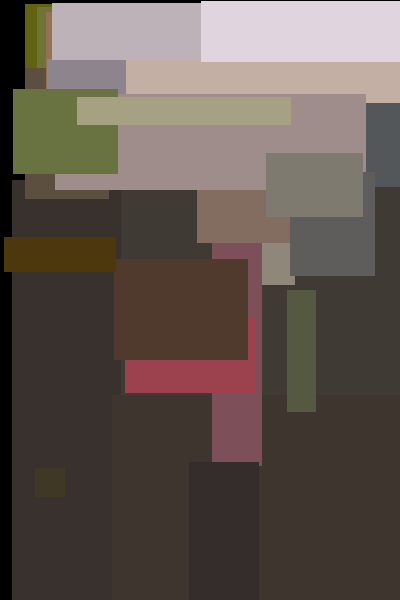

In [9]:

IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 100000
SELECTED_SHAPE = Rect  # We will build the image using only Rectangles for now

# Load the target image
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 

# 3. Initialize the Genotype (Empty)
start_geno = Genotype(w, h)

# Add 1 initial random shape so we don't start empty
start_geno.shapes.append(get_random_shape(SELECTED_SHAPE, w, h))

# 4. Run the Local Search
# This uses the function we just wrote to improve the image
final_geno = local_search(
    geno=start_geno, 
    original_img=original_img, 
    shape_class=SELECTED_SHAPE, 
    max_it=MAX_ITERATIONS
)

# 5. Render and Display the Final Result
print(f"Final Genotype has {len(final_geno.shapes)} shape(s).")
final_phenotype = generate_phenotype(w, h, final_geno.shapes)
Image.fromarray(final_phenotype)


So brute force is a no-no. 
Now is time to add new heuristics, with a starting genotype that guesses what a conveninient starting point could be. 

## 1st Heuristic tested:

Start with a "gridification" of the image, adding a shape in each grid cells and using the mean color of the cell in the original image as the color of the shape. That should give us a much better starting point.

This is implemented in `utils/initialize_grid`.

Image loaded and resized to: 400x600
Seeding complete. Genotype initialized with 100 shapes.


Optimizing: 100%|█████████▉| 9999/10000 [00:18<00:00, 529.54it/s, Score=502,764,635, Stag=1e+4]


Stopping early due to stagnation at iteration 9999


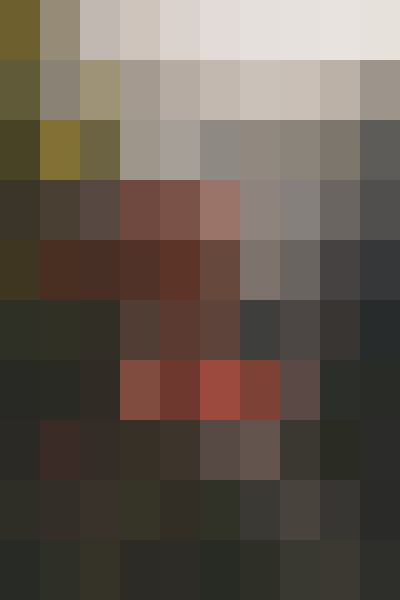

In [8]:
from utils import initialize_grid, load_img, local_search, generate_phenotype
from genotype import Rect
from PIL import Image

IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 10000
SELECTED_SHAPE = Rect  

# Load Image
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 

# 3. Initialize Genotype grid heuristic
start_geno = initialize_grid(original_img, w, h, SELECTED_SHAPE, grid_size=10)

print(f"Seeding complete. Genotype initialized with {len(start_geno.shapes)} shapes.")

# 4. Run Local Search
# The search now starts with a decent score instead of a terrible one
final_geno = local_search(
    geno=start_geno, 
    original_img=original_img, 
    shape_class=SELECTED_SHAPE, 
    max_it=MAX_ITERATIONS, 
    patience=10000
)

# 5. Result
final_phenotype = generate_phenotype(w, h, final_geno.shapes)
Image.fromarray(final_phenotype)

Problem here is that because my first approximation is a pretty good one, I'm actually not improving after because i'm trying to add random colored shapes etc. 

### Solution?

My mutations need to start being smarter. New shapes added should use the same logic (taking the average color for the area they cover).

After that resizes should be less random (small step resizes?)

FUNCTION ApplyMutation(genotype, image):
    mutation_type = RandomChoice(["Add", "Resize", "Move"], weights=[0.4, 0.3, 0.3])

    IF mutation_type IS "Add":
        # Shape of the average color of its location
        shape = RandomShape()
        region = image[shape.y : shape.y + shape.h, shape.x : shape.x + shape.w]
        shape.color = AverageColor(region)
        genotype.append(shape)

    ELSE IF mutation_type IS "Resize":
        # Resize slightly (+/- 10%)
        shape = RandomChoice(genotype.shapes)
        delta_w = RandomInteger(-5, 5)
        delta_h = RandomInteger(-5, 5)
        shape.width  = Clamp(shape.width + delta_w, min_size, image.width)
        shape.height = Clamp(shape.height + delta_h, min_size, image.height)

    ELSE IF mutation_type IS "Move":
        # cahnge position only slightly
        shape = RandomChoice(genotype.shapes)
        delta_x = RandomInteger(-10, 10)
        delta_y = RandomInteger(-10, 10)
        shape.x = Clamp(shape.x + delta_x, 0, image.width)
        shape.y = Clamp(shape.y + delta_y, 0, image.height)

In [17]:
# So I don't have to restarat kernel all the time, wish I had googles it before...
%load_ext autoreload 
%autoreload 2

import numpy as np
import random
from PIL import Image
from tqdm import tqdm

# Import Shapes
from genotype import Genotype, Rect, Circle, Ellipse

# Import utils (for loading images, etc.)
from utils import load_img, generate_phenotype, compute_fitness, initialize_grid

# Import mutation from new file
from mutation import apply_mutation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Image loaded and resized to: 400x600


Optimizing: 100%|██████████| 2000/2000 [00:06<00:00, 317.71it/s, Score=568,798,232, Stag=7]


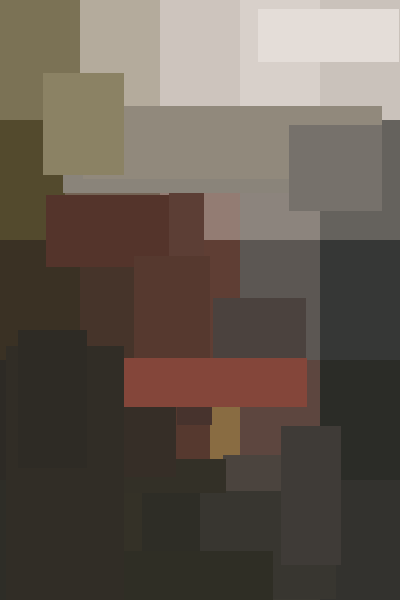

In [ ]:
# 1. Configuration
IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 10000  # Increased iterations for fine-tuning
SELECTED_SHAPE = Rect

# 2. Load Image & Initialize Grid Seeding
# Start with a 5x5 grid approximation instead of an empty canvas
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 
start_geno = initialize_grid(original_img, w, h, SELECTED_SHAPE, grid_size=5)

# 3. Define Local Search Strategy
def local_search(geno, original_img, shape_class, max_it=10000, patience=10000):
    """
    Hill Climbing search that optimizes the genotype by applying random mutations
    and keeping changes that improve the fitness score (SSD).
    """
    best_geno = geno.clone()
    best_phenotype = generate_phenotype(best_geno.w, best_geno.h, best_geno.shapes)
    best_score = compute_fitness(original_img, best_phenotype)
    
    no_improve = 0
    pbar = tqdm(range(max_it), desc="Optimizing")
    
    for i in pbar:
        neighbour = best_geno.clone()
        
        
        # Apply mutation:
        delta = random.uniform(0, 0.2)
        move = random.randint(10, 20)

        apply_mutation(
            neighbour, 
            shape_class, 
            original_img=original_img, 
            mutation_type="random", 
            delta_scale=delta, 
            move_range=move
        )
        
        # Evaluate fitness
        pheno = generate_phenotype(neighbour.w, neighbour.h, neighbour.shapes)
        score = compute_fitness(original_img, pheno)
        
        # Selection: Keep if score improves (lower is better)
        if score < best_score:
            best_geno = neighbour
            best_score = score
            no_improve = 0
            pbar.set_postfix({"Score": f"{best_score:,}", "Stag": 0})
        else:
            no_improve += 1
            pbar.set_postfix({"Score": f"{best_score:,}", "Stag": no_improve})
            
        # Early Stopping
        if no_improve >= patience:
            print(f"Stagnation reached at iteration {i}")
            break
            
    return best_geno

# 4. Execute Optimization
final_geno = local_search(start_geno, original_img, SELECTED_SHAPE, MAX_ITERATIONS)

# 5. Visual Result
display(Image.fromarray(generate_phenotype(w, h, final_geno.shapes)))

## A ajouter

- Evolution de la fitness du debut a la fin pour comprendre la difficulté a ajouter
- 

# Loss Analysis

Let's analyse the loss by iteration, this will help us check what method is fastest.


In [1]:
import matplotlib.pyplot as plt
from typing import List

def plot_fitness(loss_history: List[float]):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Fitness Evolution (Lower is Better)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss (SSD)")
    plt.grid(True, alpha=0.3)
    plt.show()




In [14]:
%load_ext autoreload
%autoreload 2

import random 
import numpy as np
from PIL import Image
from tqdm import tqdm

# Import your classes
from genotype import Genotype, Rect, Circle, Ellipse

# Import utils (for loading images, etc.)
from utils import load_img, generate_phenotype, compute_fitness, initialize_grid, get_random_shape

# CRITICAL CHANGE: Import mutation from your new file
from mutation import apply_mutation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Image loaded and resized to: 400x600


Optimizing: 100%|██████████| 10000/10000 [02:19<00:00, 71.92it/s, Score=456,013,972, Stag=5]  


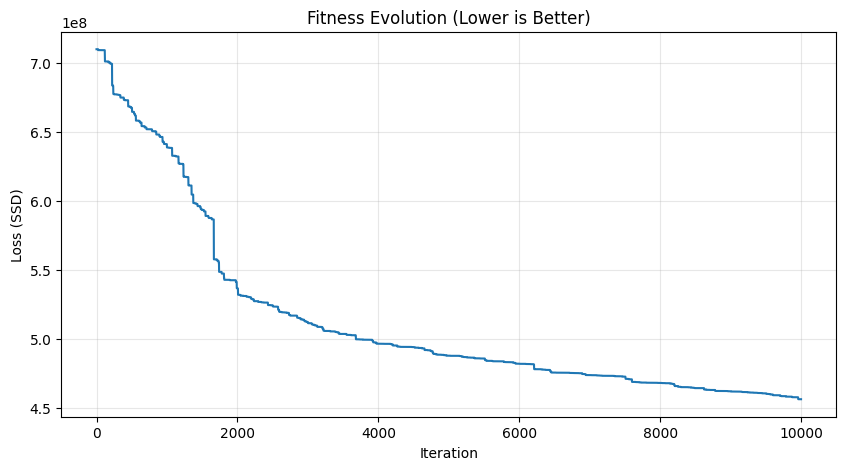

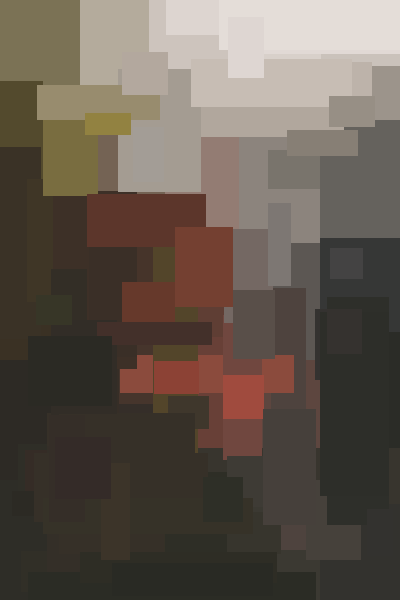

In [5]:
# 1. Configuration
IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 10000  # Increased iterations for fine-tuning
SELECTED_SHAPE = Rect

# 2. Load Image & Initialize Grid Seeding
# Start with a 5x5 grid approximation instead of an empty canvas
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 
start_geno = initialize_grid(original_img, w, h, SELECTED_SHAPE, grid_size=5)

# 3. Define Local Search Strategy
def local_search(geno, original_img, shape_class, max_it=10000, patience=10000):
    """
    Hill Climbing search that optimizes the genotype by applying random mutations
    and keeping changes that improve the fitness score (SSD).
    """
    best_geno = geno.clone()
    best_phenotype = generate_phenotype(best_geno.w, best_geno.h, best_geno.shapes)
    best_score = compute_fitness(original_img, best_phenotype)
    
    history = [] # History of our fitness scores per iteration

    no_improve = 0
    pbar = tqdm(range(max_it), desc="Optimizing")
    
    for i in pbar:
        neighbour = best_geno.clone()
        
        
        # Apply mutation:
        delta = random.uniform(0, 0.2)
        move = random.randint(10, 20)

        apply_mutation(
            neighbour, 
            shape_class, 
            original_img=original_img, 
            mutation_type="random", 
            delta_scale=delta, 
            move_range=move
        )
        
        # Evaluate fitness
        pheno = generate_phenotype(neighbour.w, neighbour.h, neighbour.shapes)
        score = compute_fitness(original_img, pheno)
        
        # Selection: Keep if score improves (lower is better)
        if score < best_score:
            best_geno = neighbour
            best_score = score
            no_improve = 0
            pbar.set_postfix({"Score": f"{best_score:,}", "Stag": 0})
        else:
            no_improve += 1
            pbar.set_postfix({"Score": f"{best_score:,}", "Stag": no_improve})

        # Add current best score to history
        history.append(best_score)
            
        # Early Stopping
        if no_improve >= patience:
            print(f"Stagnation reached at iteration {i}")
            break
            
    return best_geno, history

# 4. Execute Optimization
final_geno, history = local_search(start_geno, original_img, SELECTED_SHAPE, MAX_ITERATIONS)
# Print loss
plot_fitness(history)
# 5. Visual Result
display(Image.fromarray(generate_phenotype(w, h, final_geno.shapes)))



In [ ]:
import math

def simulated_annealing(geno, original_img, shape_class, max_it=1000, 
                        initial_temp=1000, cooling_rate=0.995):
    """
    Simulated Annealing optimization.
    Allows accepting worse solutions early on to escape local optima.
    """
    # 1. Initialization
    # Current working solution
    current_geno = geno.clone()
    current_pheno = generate_phenotype(current_geno.w, current_geno.h, current_geno.shapes)
    current_score = compute_fitness(original_img, current_pheno)
    
    # Global best (to keep track of the absolute best we've seen)
    best_geno = current_geno.clone()
    best_score = current_score
    
    history = [best_score]
    T = initial_temp # This is our hyperparam
    
    pbar = tqdm(range(max_it), desc="Annealing")
    
    for i in pbar:
        # 2. Create Neighbour
        neighbour = current_geno.clone()
        
        # Apply Mutation (using your randomized params)
        apply_mutation(
            neighbour, 
            shape_class, 
            original_img=original_img, 
            mutation_type="random", 
            delta_scale=random.uniform(0, 0.2), 
            move_range=random.randint(10, 20)
        )
        
        # Eval of neighbour
        neighbour_pheno = generate_phenotype(neighbour.w, neighbour.h, neighbour.shapes)
        neighbour_score = compute_fitness(original_img, neighbour_pheno)
        dif = neighbour_score - current_score
        
        # 
        accept = False
        
        if dif < 0:
            accept = True
            
        else:
            # If not better, calculate probability and check if accept
            # We guard against divide by zero or overflow
            if T > 0.001:
                probability = math.exp(-dif / T)
                if random.random() < probability:
                    accept = True
        
        
        if accept:
            current_geno = neighbour
            current_score = neighbour_score
            
            # Check if it's a new Best
            if current_score < best_score:
                best_geno = current_geno.clone()
                best_score = current_score
        
        # Cool Down
        T *= cooling_rate
        
        # Logging
        history.append(best_score)
        pbar.set_postfix({"Best": f"{best_score:,}", "Temp": f"{T:.1f}"})
            
    return best_geno, history



Image loaded and resized to: 400x600


Annealing: 100%|██████████| 10000/10000 [02:50<00:00, 58.81it/s, Best=451,780,163, Temp=0.0] 


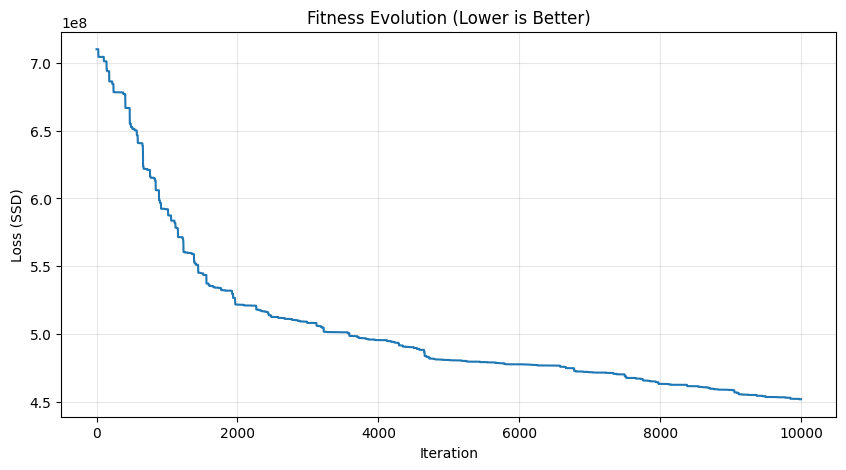

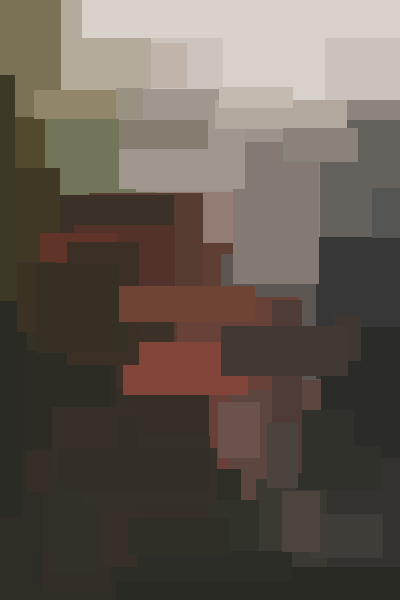

In [7]:
# Configuration
IMAGE_PATH = "./test.png"
MAX_ITERATIONS = 10000  # Increased iterations for fine-tuning
SELECTED_SHAPE = Rect

# Load Image & Initialize Grid Seeding
# Start with a 5x5 grid approximation instead of an empty canvas
original_img, w, h = load_img(IMAGE_PATH, max_size=600) 
start_geno = initialize_grid(original_img, w, h, SELECTED_SHAPE, grid_size=5)

# Execute Optimization
final_geno, history = simulated_annealing(start_geno, original_img, SELECTED_SHAPE, MAX_ITERATIONS)
# Print loss
plot_fitness(history)
# Visual Result
display(Image.fromarray(generate_phenotype(w, h, final_geno.shapes)))



# Implement Genetic Algorithm

Let's now try to see how simple implementations of genetic algorithms perform.

In [8]:
# First let's implement crossover


def crossover_uniform(parent1: Genotype, parent2: Genotype) -> Genotype:
    """
    Standard crossover: Child gets 50% of genes from Parent A and 50% from Parent B.
    Maintains the same number of shapes.
    """
    child = Genotype(parent1.w, parent1.h)
    min_len = min(len(parent1.shapes), len(parent2.shapes))
    
    for i in range(min_len):
        if random.random() > 0.5:
            child.shapes.append(parent1.shapes[i].copy())
        else:
            child.shapes.append(parent2.shapes[i].copy())
    return child

def crossover_concat(parent1: Genotype, parent2: Genotype) -> Genotype:
    """
    Concatenation: Child inherits ALL shapes from BOTH parents.
    Doubles the DNA size (approx).
    """
    child = Genotype(parent1.w, parent1.h)
    # Combine lists
    child.shapes = [s.copy() for s in parent1.shapes] + [s.copy() for s in parent2.shapes]
    return child

def apply_crossover(parent1: Genotype, parent2: Genotype, method: str = "uniform") -> Genotype:
    """
    Dispatcher for crossover methods.
    
    Args:
        method: 'uniform' (mix) or 'concat' (combine all).
    """
    if method == "concat":
        return crossover_concat(parent1, parent2)
    else:
        return crossover_uniform(parent1, parent2)

In [18]:

def genetic_algorithm(original_img, shape_class, pop_size=50, max_it=1000, 
                      selection_method="tournament", crossover_type="uniform", 
                      mutation_rate=0.5):
    
    w, h = original_img.shape[1], original_img.shape[0]
    
    # 1. Initialize Population
    # I start by creating a list of random genotypes
    population = []
    print("Initializing Population...")
    
    for _ in range(pop_size):
        # Create a new empty genotype
        geno = Genotype(w, h)
        # Add one random shape to start
        geno.shapes.append(get_random_shape(shape_class, w, h)) 
        population.append(geno)

    best_global_score = float('inf')
    history = []
    
    # Setup the progress bar
    pbar = tqdm(range(max_it), desc=f"GA ({selection_method})")
    
    for iteration in pbar:
        
        # 2. Evaluation Phase
        # I only calculate fitness if it is missing (None)
        # This saves a lot of time by not re-rendering unchanged survivors
        for geno in population:
            if geno.fitness is None:
                pheno = generate_phenotype(w, h, geno.shapes)
                geno.fitness = compute_fitness(original_img, pheno)
        
        # 3. Sort Population
        # Sort individuals by fitness (lowest score is best)
        population.sort(key=lambda g: g.fitness)
        
        # 4. Elitism & Stats
        # Always keep the single best individual for the next generation
        best_current = population[0]
        
        # Update global best if we found a new record
        if best_current.fitness < best_global_score:
            best_global_score = best_current.fitness
            # Save a clone so future mutations don't ruin my record
            best_global_geno = best_current.clone()
        
        history.append(best_global_score)
        pbar.set_postfix({"Best": f"{best_global_score:,}", "Shapes": len(best_current.shapes)})

        # 5. Create Next Generation
        # Start the new list with the elite survivor
        next_gen = [best_current.clone()] 
        
        while len(next_gen) < pop_size:
            
            # A. Selection (Pick Parents)
            parent1, parent2 = None, None
            
            if selection_method == "tournament":
                # Pick 3 random fighters, winner is the one with best fitness
                # I do this twice to get two parents
                k = 3
                p1 = min(random.sample(population, k), key=lambda g: g.fitness)
                p2 = min(random.sample(population, k), key=lambda g: g.fitness)
                parent1, parent2 = p1, p2
                
            else:
                # Greedy: Randomly pick from the top 20%
                top_k = max(2, int(pop_size * 0.2))
                top_20 = population[:top_k]
                parent1 = random.choice(top_20)
                parent2 = random.choice(top_20)

            # B. Crossover (Mix DNA)
            # Use the helper function to mix parents (uniform or concat)
            child = apply_crossover(parent1, parent2, method=crossover_type)
            
            # C. Mutation (Add Variety)
            if random.random() < mutation_rate:
                apply_mutation(
                    child, 
                    shape_class, 
                    original_img=original_img, 
                    mutation_type="random", 
                    delta_scale=0.1, 
                    move_range=15
                )
                # CRITICAL: Since I mutated the child, its fitness is no longer valid
                child.fitness = None
            
            next_gen.append(child)
            
        # 6. Update Population
        # The children become the parents of the next generation
        population = next_gen
            
    return best_global_geno, history

## We can now test both types of selection methods

--- Running Greedy GA (Pop: 50, Gens: 300) ---
Initializing Population...


GA (greedy):   0%|          | 0/300 [00:00<?, ?it/s]

GA (greedy): 100%|██████████| 300/300 [01:28<00:00,  3.38it/s, Best=509,997,311, Shapes=34] 



--- Running Tournament GA (Pop: 50, Gens: 300) ---
Initializing Population...


GA (tournament): 100%|██████████| 300/300 [01:22<00:00,  3.63it/s, Best=726,322,250, Shapes=10]


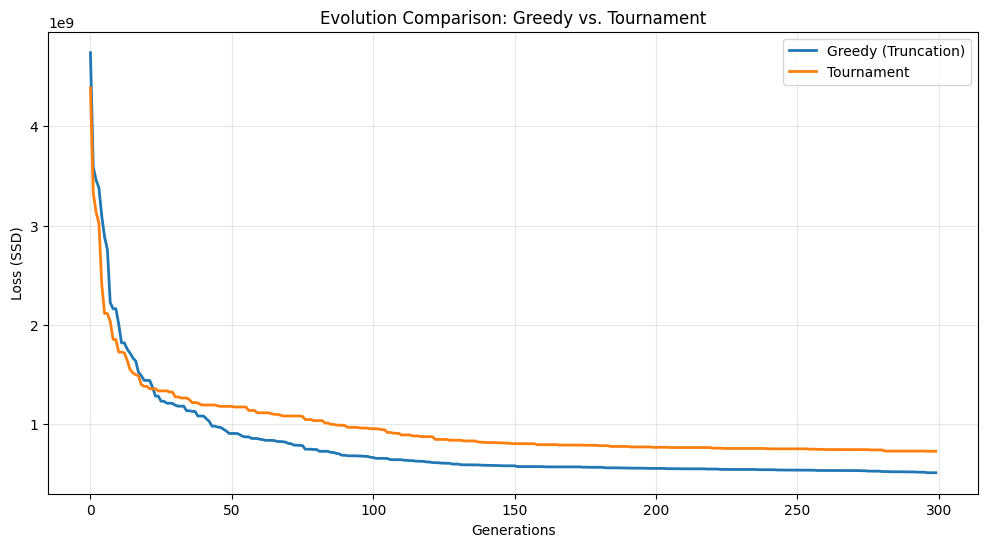

Result: Greedy Selection


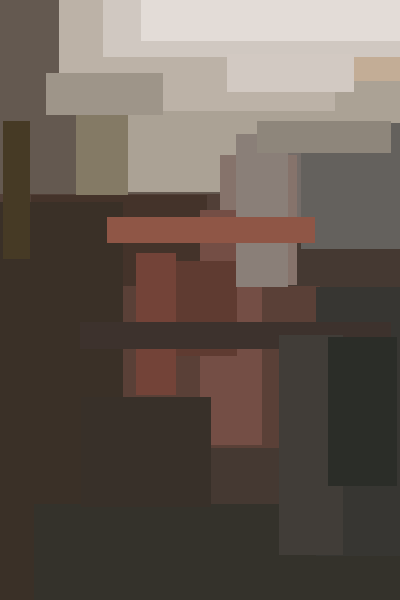

Result: Tournament Selection


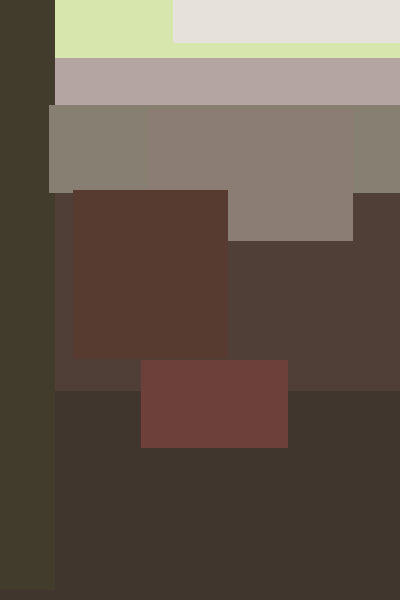

In [19]:
# Config
# We use a smaller population/iterations for the test to keep it fast
POP_SIZE = 50
MAX_GENERATIONS = 300
MUTATION_RATE = 0.6
SELECTION_SHAPE = Rect


# TEST 1: GREEDY SELECTION
print(f"--- Running Greedy GA (Pop: {POP_SIZE}, Gens: {MAX_GENERATIONS}) ---")
best_greedy, hist_greedy = genetic_algorithm(
    original_img=original_img, 
    shape_class=SELECTION_SHAPE, 
    pop_size=POP_SIZE, 
    max_it=MAX_GENERATIONS, 
    selection_method="greedy",
    crossover_type="uniform",
    mutation_rate=MUTATION_RATE
)

# TEST 2: TOURNAMENT SELECTION
print(f"\n--- Running Tournament GA (Pop: {POP_SIZE}, Gens: {MAX_GENERATIONS}) ---")
best_tourn, hist_tourn = genetic_algorithm(
    original_img=original_img, 
    shape_class=SELECTION_SHAPE, 
    pop_size=POP_SIZE, 
    max_it=MAX_GENERATIONS, 
    selection_method="tournament",
    crossover_type="uniform",
    mutation_rate=MUTATION_RATE
)


# A. Plot the fitness history
plt.figure(figsize=(12, 6))
plt.plot(hist_greedy, label="Greedy (Truncation)", linewidth=2)
plt.plot(hist_tourn, label="Tournament", linewidth=2)
plt.title("Evolution Comparison: Greedy vs. Tournament")
plt.xlabel("Generations")
plt.ylabel("Loss (SSD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# B. Show the final images
print("Result: Greedy Selection")
display(Image.fromarray(generate_phenotype(w, h, best_greedy.shapes)))

print("Result: Tournament Selection")
display(Image.fromarray(generate_phenotype(w, h, best_tourn.shapes)))